<h1> Dylan Abramson Final Project And Research Toolkit</h1>
<h4>
This notebook includes my final project, as well as a collection of auxiallary functions that are useful for my thesis/MD related stuff
</h4>
<h2> Table of contents </h2>




<h3> Tools </h3>

[Trajectory Analysis](#trajectory_id) 


[Plot Energy](#energy_id)


<h3> Project </h3>

[RMSD Clustering](#rmsd_id)


[Dihedral Clustering](#dihed_id)


[Graph Neural Network](#rmsd_id)


<h3> Helpful Documentation </h3>

<a href="https://amber-md.github.io/pytraj/latest/atom_mask_selection.html"> Masks in Pytraj</a>

    



<a id='trajectory_id'/>

In [1]:
import pytraj as pt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class TrajectoryBuilder():
    '''
    A wrapper class for calling common trajectory functions. All functions cache results for faster 
    access. 
    '''
    def __init__(self,trajectory_file,topology,mask = '@*',skip=1):
        self.computed_dic = {'rmsd' : False, 'k_means' : False}
        self.mask = mask
        self.trajectory_file = trajectory_file
        self.topology = topology
        self.trajectory = pt.Trajectory(trajectory_file, topology)[mask][0::skip]

    def compute_rmsd(self):
        '''
        Compute rmsd for a system
        '''
        self.rmsd = pt.rmsd(traj=self.trajectory)
        self.computed_dic['rmsd'] = True
        return self.rmsd
    
    def plot_rmsd(self):
        '''
        Plot rmsd for a system
        '''
        if not self.computed_dic['rmsd']:
            self.compute_rmsd()
        df = pd.DataFrame(self.rmsd)
        df.plot()
    
    def compute_kmeans(self,num_clusters):
        self.num_clusters = num_clusters
        self.k_means = pt.cluster.kmeans(self.trajectory,n_clusters=num_clusters)
        self.computed_dic['k_means'] = True
        return self.k_means
    
    def build_MSM(self,num_clusters = None):
        if not self.computed_dic['k_means']:
            self.compute_kmeans(3)
        transition_matrix = [[0] * self.num_clusters for num in range(self.num_clusters)]
        cluster_indices = self.k_means.cluster_index
        for index in range(len(cluster_indices) - 1):
            transition_matrix[cluster_indices[index]][cluster_indices[index+1]] += 1 
        return transition_matrix
    




<a id='energy_id'/>

In [2]:
#!/usr/bin/env python3
import sys
import subprocess as sp
import re
import matplotlib.pyplot as plt
import pandas as pd

def plot_energy(file):
    bytes = sp.check_output(['grep','Etot',file])
    text = bytes.decode("utf-8")

    split_text = text.split('\n')
    split_text.pop()
    data = [re.findall('-\d+\.\d+',text)[0] if len(re.findall('-\d+\.\d+',text)) > 0 else None for text in split_text]
    data = list(filter(lambda x: x != None,data))
    data = [float(val) for val in data]

    df = pd.DataFrame(data)


    plt.figure()
    df.plot()

    plt.show()


In [3]:
def regex_lite(s):
    '''
    This makes selecting certain hydrogens in the mask easier.
    '''
    firstMatch = s.index('[')
    secondMatch = s.index(']')
    f = s[firstMatch+1:secondMatch].split('-')
    arr = []
    bound1 = int(f[0])
    bound2 = int(f[1])
    for i in range(bound1,bound2+1):
        arr.append(f'H{i}')
    return ",".join(arr)



<h2> Hexane </h2>

In [4]:
hydrogens = regex_lite('H[1-10]')
mask = '@C*,H,' + hydrogens

traj = TrajectoryBuilder('Hexane/Hexane_wat_strip.trj','Hexane/Hexane_nowat.prmtop',mask)
trajectory1 = traj.trajectory
trajectory1.top.set_nobox()
trajectory1.superpose(ref=0)
view = trajectory1.view()
view





NGLWidget(max_frame=25049)

<h2> Hexanol </h2>

In [5]:
hydrogens = regex_lite('H[1-10]')
mask = '@C*,H,' + hydrogens
traj2 = TrajectoryBuilder('Hexanol/Hexanol_wat_strip.trj','Hexanol/Hexanol_nowat.prmtop',mask)
trajectory2 = traj2.trajectory
trajectory2.superpose(ref=0)
view = trajectory2.view()
view



NGLWidget(max_frame=25009)

<h2> Hexanoic Regular (common substructure of Alkanes)</h2>

In [6]:
hydrogens = regex_lite('H[1-10]')
mask = '@C*,H,' + hydrogens
traj3 = TrajectoryBuilder('Hexanoic/Hexanoic_wat_strip.trj','Hexanoic/Hexanoic_nowat.prmtop',mask)
trajectory3 = traj3.trajectory
trajectory3.superpose(ref=0)
view = trajectory3.view()
view


NGLWidget(max_frame=25049)

<h2> Hexanoic Control (common substructure with Cyclic Hexane)</h2>

In [47]:
mask = '@C,C1,C2,C3,C4'
trajHexCtr1 = TrajectoryBuilder('Hexanoic/Hexanoic_wat_strip.trj','Hexanoic/Hexanoic_nowat.prmtop',mask)
trajectoryCtr1 = trajHexCtr1.trajectory
trajectoryCtr1.top.set_nobox()
trajectoryCtr1.superpose(ref=0)
view = trajectoryCtr1.view()
view

NGLWidget(max_frame=25049)

<h2> Cyclic Hexane </h2>

In [52]:
mask = '@C,C1,C2,C3,C4'

trajCycCtr = TrajectoryBuilder('Cyclic/Cyclic_wat_strip.trj','Cyclic/Cyclic_nowat.prmtop',mask)
trajectoryCtr2 = trajCycCtr.trajectory
trajectoryCtr2.top.set_nobox()
trajectoryCtr2.superpose(ref=0)
view = trajectoryCtr2.view()
view

NGLWidget(max_frame=25049)

<h2> Control </h2>
<p> Just to make sure that k-means in pytraj is working the way I expect, I will cluster the concatenated trajectories of Hexanoic (arbitrarily chosen) and cyclic hexane. This should <b> definitely </b> produce distinct clusters as Cyclic hexane really only has one confirmation. I added this section after observing a null result when clustering on standard chain variations of hexane</p>

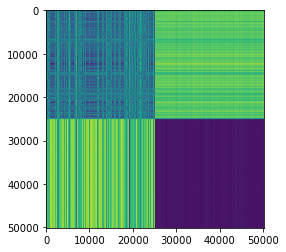

In [36]:
fig, ax = plt.subplots()

plt.imshow(pt.pairwise_rmsd(control))
plt.show()


<h3> Output from above cell shows we should clearly only have one cluster for Cyclic Hexane </h3>

In [504]:
control = pt.Trajectory(top=trajectoryCtr1.top)

for frame in trajectoryCtr1:
    control.append(frame)


for frame in trajectoryCtr2:
    control.append(frame)

In [505]:
clusters = pt.cluster.kmeans(control,n_clusters=5)

[0.00702595 0.4207984  0.27772455 0.15389222 0.14055888]


Text(0.5, 1.0, 'Functional Group Cluster Frequencies')

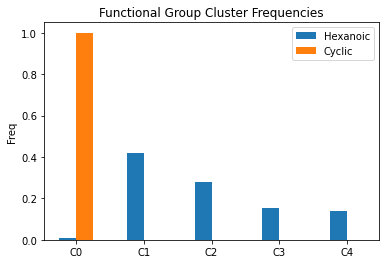

In [506]:
hexanoic_clusters = clusters.cluster_index[:25050]
cyclic_clusters =  clusters.cluster_index[25050:]

ind = np.arange(5)
width = 0.25

fig, ax = plt.subplots(1,1)

unique1, count1 = np.unique(hexanoic_clusters, return_counts = True)
clusterFreqHexanoic = count1/sum(count1)
print(clusterFreqHexanoic)

unique2, count2 = np.unique(cyclic_clusters, return_counts = True)
clusterFreqCyclic = count2/sum(count2)
#cyclic only has one cluster with 1 hundred percent frequency so we have to add other
#bins to get correct plot
clusterFreqCyclic = np.append(clusterFreqCyclic,np.zeros((4,1)))



recs1 = ax.bar(ind - width/2,clusterFreqHexanoic,width,label="Hexanoic")
recs2 = ax.bar(ind+width/2,clusterFreqCyclic,width,label="Cyclic")

ax.set_xticks(ind)
ax.set_xticklabels(('C0','C1', 'C2','C3','C4',))
ax.legend()

ax.set_ylabel('Freq')
ax.set_title('Functional Group Cluster Frequencies')


<p> Okay, gut check passed. We got the result we hoped for. </p>

In [21]:
<a id='trajectory_id'/>#Concatenate trajectories for k-means clustering
t0 = pt.Trajectory(top=traj.trajectory.top)

for frame in trajectory1:
    t0.append(frame)


for frame in trajectory2:
    t0.append(frame)


for frame in trajectory3:
    t0.append(frame)

<a id='rmsd_id'/>

<h1> RMSD MSM's </h1>

In [23]:
#Calculate the clusters this is super computationally expensive so commented out here
# clusters = pt.cluster.kmeans(t0,n_clusters=10,options='summary summary.out')
# this was saved in clusters.npy
# np.save('clusters.npy',clusters.cluster_index)


In [27]:
def MSM(num_clusters,indices):
    transition_matrix = [[0] * num_clusters for num in range(num_clusters)]
    for index in range(len(indices) - 1):
        transition_matrix[indices[index]][indices[index+1]] += 1 
    return transition_matrix

Text(0.5, 1.0, 'Functional Group Cluster Frequencies')

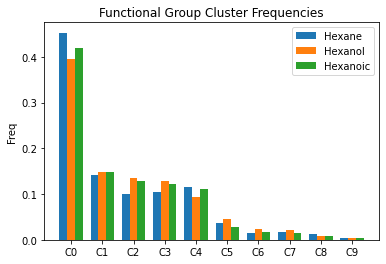

In [25]:
hex_clusters = np.load('clusters.npy')
'''
Here we slice according to the frames that compose each trajectory to plot 
which clusters each trajectory inhabited. 
'''
hexane_clusters = hex_clusters[:25050]
hexanol_clusters =  hex_clusters[25050:50060]
hexanoic_clusters =  hex_clusters[50060:]

ind = np.arange(10)
width = 0.25

fig, ax = plt.subplots(1,1)

unique1, count1 = np.unique(hexane_clusters, return_counts = True)
clusterFreqHexane = count1/sum(count1)

unique2, count2 = np.unique(hexanol_clusters, return_counts = True)
clusterFreqHexanol = count2/sum(count2)

unique3, count3 = np.unique(hexanoic_clusters, return_counts = True)
clusterFreqHexanoic = count3/sum(count3)



recs1 = ax.bar(ind - width,clusterFreqHexane,width,label="Hexane")
recs2 = ax.bar(ind,clusterFreqHexanol,width,label="Hexanol")
recs3 = ax.bar(ind + width,clusterFreqHexanoic,width,label="Hexanoic")

ax.set_xticks(ind)
ax.set_xticklabels(('C0','C1', 'C2','C3','C4','C5','C6','C7','C8','C9'))
ax.legend()

ax.set_ylabel('Freq')
ax.set_title('Functional Group Cluster Frequencies')

In [31]:
print(MSM(10,hex_clusters[:25050]),'\n')
print(MSM(10,hex_clusters[25050:50060]),'\n')
print(MSM(10,hex_clusters[50060:]),'\n')

[[10926, 117, 91, 84, 117, 0, 3, 2, 1, 3], [110, 3365, 19, 31, 5, 26, 2, 3, 4, 0], [96, 15, 2376, 2, 3, 0, 11, 8, 0, 19], [97, 27, 1, 2444, 8, 2, 13, 6, 0, 0], [109, 4, 2, 15, 2738, 16, 0, 0, 7, 22], [4, 23, 0, 1, 15, 888, 0, 1, 12, 1], [0, 4, 11, 13, 0, 0, 310, 20, 0, 0], [0, 3, 10, 8, 0, 1, 18, 366, 0, 1], [0, 7, 0, 0, 5, 12, 0, 0, 275, 1], [2, 0, 20, 0, 22, 0, 1, 1, 1, 42]] 

[[9487, 106, 106, 86, 76, 3, 1, 1, 0, 1], [111, 3489, 16, 23, 2, 29, 4, 3, 7, 0], [101, 20, 3197, 1, 1, 1, 13, 9, 0, 22], [88, 23, 1, 3035, 8, 7, 17, 18, 0, 0], [77, 0, 4, 11, 2240, 13, 0, 0, 5, 18], [2, 29, 0, 6, 16, 1091, 0, 2, 7, 1], [0, 0, 17, 16, 0, 0, 505, 27, 0, 0], [2, 6, 7, 18, 0, 2, 25, 462, 0, 0], [0, 11, 0, 0, 4, 4, 0, 0, 190, 0], [0, 0, 17, 0, 21, 4, 0, 0, 0, 36]] 

[[10125, 100, 100, 98, 87, 1, 0, 1, 1, 0], [109, 3544, 13, 13, 1, 20, 5, 4, 5, 2], [93, 16, 3045, 0, 2, 0, 14, 10, 0, 17], [94, 13, 0, 2922, 18, 0, 11, 12, 0, 0], [87, 2, 0, 9, 2634, 17, 0, 0, 6, 20], [1, 25, 0, 0, 12, 657, 0, 0, 6, 0],


<p> Looking at the clustering data and MSM, it's clear that the MSM's are not picking up on anything other than statisical noise. </p>

<h1> Dihedral MSM's </h1>

<a id='dihed_id'/>

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

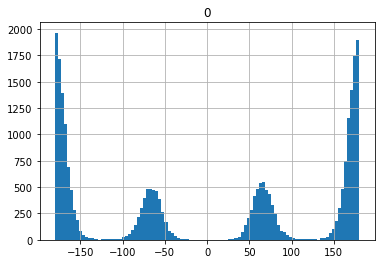

In [32]:
hexaneDihedral1 = pt.dihedral(trajectory1, '@C2 @C3 @C4 @C5')
hexaneDihedralDF1 = pd.DataFrame(hexaneDihedral1)
hexaneDihedralDF1.hist(bins=100)



[-163.25536339 -168.53470662  173.10502414 ...  -50.23234226  -73.26464421
  -91.77947981]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

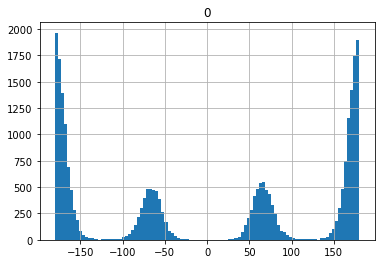

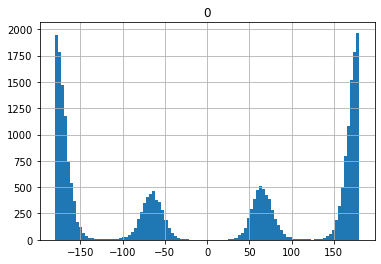

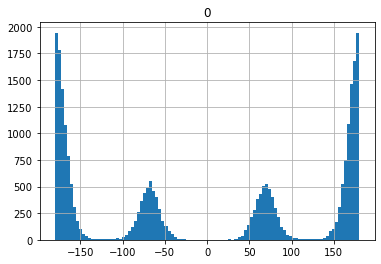

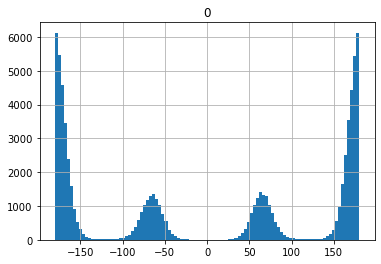

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

dihedrals1 = pt.dihedral(trajectory1,'@C2 @C3 @C4 @C5')

df1 = pd.DataFrame(dihedrals1)
df1.hist(bins=100)

dihedrals2 = pt.dihedral(trajectory2,'@C2 @C3 @C4 @C5')

df2 = pd.DataFrame(dihedrals2)
df2.hist(bins=100)

dihedrals3 = pt.dihedral(trajectory3,'@C2 @C3 @C4 @C5')
print(dihedrals3)
df3 = pd.DataFrame(dihedrals3)
df3.hist(bins=100)


dihedrals4 = pt.dihedral(t0,'@C1 @C2 @C3 @C4')

df4 = pd.DataFrame(dihedrals4)
df4.hist(bins=100)



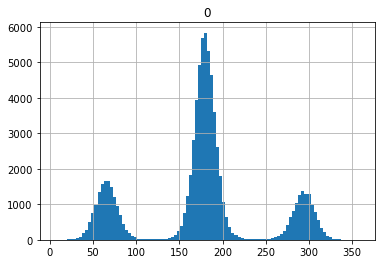

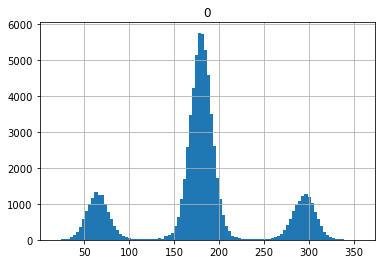

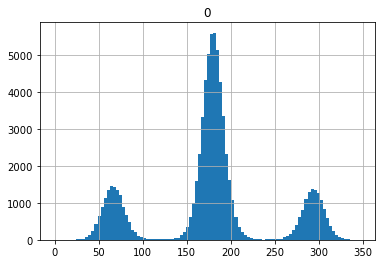

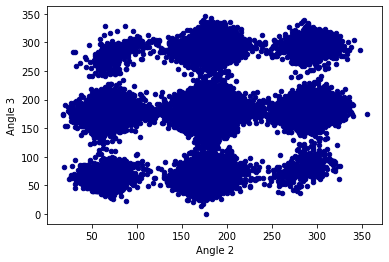

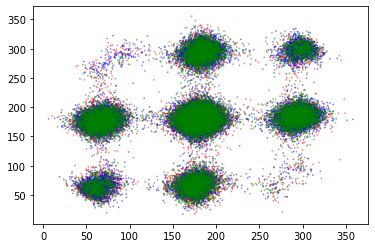

In [34]:
from sklearn import cluster as cl

def fold_distribution(vals):
    folded = []
    for val in  vals:
        if val < 0:
            folded.append(360 + val)
        else:
            folded.append(val)
    return np.array(folded)


dihedralsPlane1 = pt.dihedral(t0,'@C @C1 @C2 @C3')
foldedPlane1 = fold_distribution(dihedralsPlane1)

dihedralsPlane2 = pt.dihedral(t0,'@C1 @C2 @C3 @C4')
foldedPlane2 = fold_distribution(dihedralsPlane2)

dihedralsPlane3 = pt.dihedral(t0,'@C2 @C3 @C4 @C5')
foldedPlane3 = fold_distribution(dihedralsPlane3)

pd.DataFrame(foldedPlane1).hist(bins=100)
pd.DataFrame(foldedPlane2).hist(bins=100)
pd.DataFrame(foldedPlane3).hist(bins=100)

foldedPlane1 = foldedPlane1.reshape(-1,1)
foldedPlane2 = foldedPlane2.reshape(-1,1)
foldedPlane3 = foldedPlane3.reshape(-1,1)


merged = np.concatenate((foldedPlane1,foldedPlane2,foldedPlane3), axis=1)
df = pd.DataFrame(merged, columns=['Angle 1', 'Angle 2', 'Angle 3'])

ax1 = df.plot.scatter(x='Angle 2',
                      y='Angle 3',
                      c='DarkBlue')

fig, ax = plt.subplots()


ax.scatter(foldedPlane1[:25050], foldedPlane2[:25050], c='red', s=3, label='Hexane',
               alpha=0.5, edgecolors='none')

ax.scatter(foldedPlane1[25050:50060], foldedPlane2[25050:50060], c='Blue', s=3, label='Hexanol',
               alpha=0.5, edgecolors='none')

ax.scatter(foldedPlane1[50060:], foldedPlane2[50060:], c='green', s=3, label='Hexanoic Acid',
               alpha=0.5, edgecolors='none')




('C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8')


Text(0.5, 1.0, 'Functional Group Cluster Frequencies')

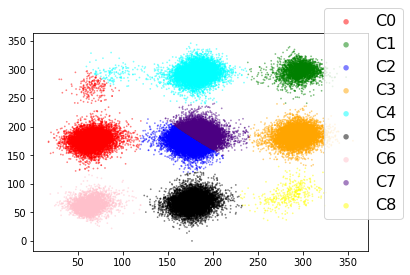

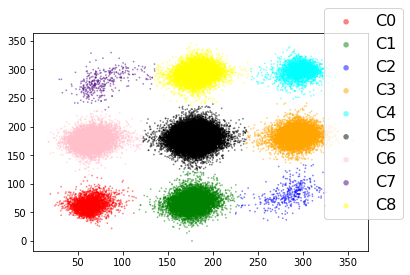

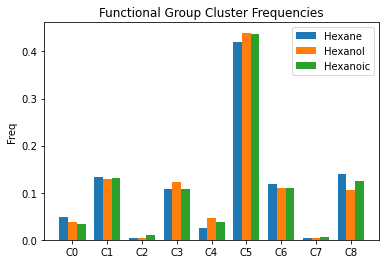

In [35]:
from sklearn import mixture as mix
from sklearn import cluster as cl

CLUSTERS = 9

merged2 = np.concatenate((foldedPlane2,foldedPlane3), axis=1)

kmeans = cl.KMeans(max_iter=1000,n_clusters=CLUSTERS).fit(merged2)

gaussianMixture = mix.GaussianMixture(means_init=[[62,66],[171,60],[283,81],[293,181],[303,290],[171,160],[68,173],[80,270],[180,290]], max_iter=10000,n_components=CLUSTERS).fit_predict(merged2)

clustersTheta2kMeans = [[] for i in range(CLUSTERS)]
clustersTheta3kMeans = [[] for i in range(CLUSTERS)]

clustersTheta2Gaussian = [[] for i in range(CLUSTERS)]
clustersTheta3Gaussian = [[] for i in range(CLUSTERS)]

for i,label in enumerate(kmeans.labels_):
    clustersTheta2kMeans[label].append(merged2[i][0])
    clustersTheta3kMeans[label].append(merged2[i][1])
    
for i,label in enumerate(gaussianMixture):
    clustersTheta2Gaussian[label].append(merged2[i][0])
    clustersTheta3Gaussian[label].append(merged2[i][1])

fig1, ax1 = plt.subplots()
for i,color in enumerate(['red','green','blue','orange','cyan','black','pink','indigo','yellow']):
    ax1.scatter(clustersTheta2kMeans[i], clustersTheta3kMeans[i], label='C' + str(i), c=color, s=3, alpha=0.5, edgecolors='none')
    
fig2, ax2 = plt.subplots()
for i,color in enumerate(['red','green','blue','orange','cyan','black','pink','indigo','yellow']):
    ax2.scatter(clustersTheta2Gaussian[i], clustersTheta3Gaussian[i], label='C' + str(i), c=color, s=3, alpha=0.5, edgecolors='none')

lgnd = fig1.legend(loc=1, prop={'size': 16})
lgnd2 = fig2.legend(loc=1, prop={'size': 16})

for i in range(CLUSTERS):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd2.legendHandles[i]._sizes = [30]


hexane_clusters = gaussianMixture[:25050]
hexanol_clusters =  gaussianMixture[25050:50060]
hexanoic_clusters =  gaussianMixture[50060:]


ind = np.arange(CLUSTERS)
width = 0.25

fig, ax = plt.subplots(1,1)

unique1, count1 = np.unique(hexane_clusters, return_counts = True)
clusterFreqHexane = count1/sum(count1)

unique2, count2 = np.unique(hexanol_clusters, return_counts = True)
clusterFreqHexanol = count2/sum(count2)

unique3, count3 = np.unique(hexanoic_clusters, return_counts = True)
clusterFreqHexanoic = count3/sum(count3)


recs1 = ax.bar(ind - width, clusterFreqHexane, width,label="Hexane")
recs2 = ax.bar(ind, clusterFreqHexanol, width, label="Hexanol")
recs3 = ax.bar(ind + width,clusterFreqHexanoic,width,label="Hexanoic")

ax.set_xticks(ind)

labels = tuple(('C' + str(i)) for i in range(CLUSTERS))
print(labels)

ax.set_xticklabels(labels)
ax.legend()

ax.set_ylabel('Freq')
ax.set_title('Functional Group Cluster Frequencies')




In [233]:
kmeans.cluster_centers_[7]

array([284.55821542,  81.71666161])

In [33]:
hexaneMSM = MSM(9,gaussianMixture[:25050])
print(hexaneMSM)
print('\n\n')
hexanolMSM = MSM(9,gaussianMixture[25050:50060])
print(hexanolMSM)
print('\n\n')
hexanoicMSM = MSM(9,gaussianMixture[50060:])
print(hexanoicMSM)


maxDif = 0
for x in range(9):
    for y in range(9):
        dif1 = hexaneMSM[x][y] - hexanolMSM[x][y]
        dif2 = hexaneMSM[x][y] - hexanoicMSM[x][y]
        dif3 = hexanolMSM[x][y] - hexanoicMSM[x][y]
        dif = max(dif1,dif2,dif3)
        if dif > maxDif:
            maxDif = dif
            print(x,y)

print(maxDif)

[[1156, 36, 1, 0, 0, 2, 19, 1, 0], [28, 3172, 21, 5, 0, 102, 1, 0, 18], [0, 25, 29, 20, 0, 1, 0, 0, 0], [0, 3, 22, 2536, 16, 98, 12, 0, 3], [0, 0, 1, 16, 598, 1, 0, 0, 18], [3, 94, 1, 95, 0, 10140, 112, 2, 99], [27, 2, 0, 16, 0, 92, 2787, 18, 7], [1, 0, 0, 0, 0, 0, 16, 35, 34], [0, 15, 0, 2, 20, 110, 2, 30, 3328]]



[[931, 27, 0, 0, 0, 2, 7, 1, 0], [21, 3109, 19, 0, 0, 96, 0, 0, 8], [1, 15, 42, 16, 1, 1, 0, 0, 1], [0, 0, 13, 2950, 17, 102, 10, 0, 3], [0, 1, 0, 23, 1114, 0, 0, 0, 17], [3, 93, 3, 92, 0, 10627, 92, 1, 86], [11, 0, 0, 12, 0, 88, 2611, 22, 1], [0, 0, 0, 0, 2, 1, 24, 43, 19], [1, 8, 0, 1, 21, 81, 1, 22, 2495]]



[[768, 29, 2, 0, 0, 2, 15, 0, 0], [29, 3155, 26, 2, 0, 86, 2, 0, 11], [3, 26, 197, 17, 0, 3, 0, 0, 0], [0, 0, 21, 2579, 16, 86, 12, 0, 1], [0, 0, 0, 12, 908, 0, 0, 4, 28], [0, 94, 0, 98, 0, 10598, 82, 1, 79], [16, 1, 0, 6, 0, 86, 2631, 15, 1], [0, 0, 0, 0, 2, 2, 11, 129, 27], [0, 6, 0, 0, 26, 89, 3, 23, 2983]]
0 0
8 8
833


<h1> GRAPH NET </h1>
<p> This last part was some experimentation with graph neural networks to see if they could detect some signal in this data. Wasn't able to get anything (even for the control) but definitely have a good pipeline for further studies </p>

In [498]:
import tensorflow as tf
tf.config.run_functions_eagerly(False) 

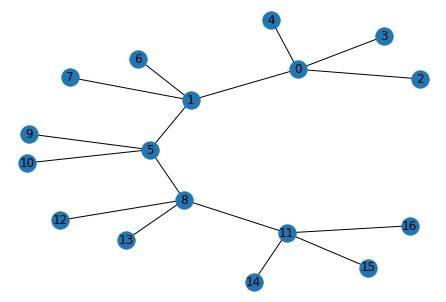

In [499]:
import sys
import math
import networkx as nx

np.set_printoptions(threshold=sys.maxsize)

def build_adjacency_from_topology(topology,for_filter):
    '''
    builds adjacency matrix with self loops
    num_atoms (int) : number of atoms in the topology
    bond_connections (array) : connections
    '''
    num_atoms = topology.n_atoms
    bond_connections = topology.bond_indices
    adjacency_matrix = np.zeros((num_atoms,num_atoms))
    for row in bond_connections:
        if for_filter:
            adjacency_matrix[row[1]][row[1]] = 1
            adjacency_matrix[row[0]][row[0]] = 1
        
        adjacency_matrix[row[0]][row[1]] = 1
        adjacency_matrix[row[1]][row[0]] = 1
       
    return adjacency_matrix


def compute_distance_tensor(trajectory):
    cutoff_vec = np.vectorize(lambda x: 0 if x > 2.5 else 1)
    matrix = pt.analysis.matrix.dist(trajectory)
    return np.vectorize(cutoff_vec)(matrix)
    
    

def compute_degree_matrix(adjacency_matrix):
    shape = adjacency_matrix.shape[0]
    degree_matrix = np.zeros((shape,shape))
    for i,row in enumerate(adjacency_matrix):
        incident_edges = np.sum(row)
        degree_matrix[i][i] = 1/math.sqrt(incident_edges)
    
    return degree_matrix

A_hat = build_adjacency_from_topology(trajectory1.top,True)
A = build_adjacency_from_topology(trajectory1.top,False)
D = compute_degree_matrix(A_hat)

G = nx.Graph(A_hat)
pos = nx.kamada_kawai_layout(G)
nx.draw(G,pos,with_labels = True)

<p> Okay, for this part I'm building my dataset. I tested a bunch of features but non seemed to work. I built one dataset for the control (5,5) and one for the normal data (17,17). The control system was binary classification on hexanoic vs cyclic, while the other test was multi-class classification with hexane,hexanol, and hexanoic. There definitely were cleaner ways I could have done this (lots of repeated appending which is expensive) </p>

In [500]:
from scipy.spatial.distance import cdist
hydrogens = regex_lite('H[1-10]')
mask = '@C*,H,' + hydrogens

hexane_trajectory = trajectory1[::5] #Slice trajectory at every fifth frame to get more movement 
hexane_data = np.empty((0,17,17))
for i in range(len(hexane_trajectory) - 1): 
    newarr = cdist(hexane_trajectory[i],hexane_trajectory[i+1]).reshape(1,17,17)
    hexane_data = np.append(hexane_data,newarr,axis=0)
    

In [501]:
data_with_labels = [(data,0) for data in hexane_data]

In [502]:
hexanol_trajectory = trajectory2[::5]
hexanol_data = np.empty((0,17,17))
for i in range(len(hexanol_trajectory) - 1): 
    newarr = cdist(hexanol_trajectory[i],hexanol_trajectory[i+1]).reshape(1,17,17)
    hexanol_data = np.append(hexanol_data,newarr,axis=0)
    

In [143]:
for data in hexanol_data:
    data_with_labels.append((data,1))

In [144]:
hexanoic_trajectory = trajectory3[::5]
hexanoic_data = np.empty((0,17,17))
for i in range(len(hexanoic_trajectory) - 1): 
    newarr = cdist(hexanoic_trajectory[i],hexanoic_trajectory[i+1]).reshape(1,17,17)
    hexanoic_data = np.append(hexanoic_data,newarr,axis=0)

In [145]:
for data in hexanoic_data:
    data_with_labels.append((data,2))

In [146]:
import random
random.shuffle(data_with_labels)

In [147]:
validation = data_with_labels[:3005]
test = data_with_labels[3005:7010]
training = data_with_labels[7010:]

training_data = [x[0] for x in training]
validation_data = [x[0] for x in validation]

X_train = np.empty((0,17,17))
for data in training_data:
    X_train = np.append(X_train,data.reshape(1,17,17),axis=0)

Y_train = [x[1] for x in training]
Y_train = np.array(Y_train)

X_val = np.empty((0,17,17)) 
for data in validation_data:
    X_val = np.append(X_val,data.reshape(1,17,17),axis=0)

Y_val = [x[1] for x in validation]
Y_val = np.array(Y_val)

Y_train = tf.keras.utils.to_categorical(Y_train)
Y_val = tf.keras.utils.to_categorical(Y_val)



In [478]:
class GraphConvolution(tf.keras.layers.Layer):
    '''
    Implemented this based on this paper: https://arxiv.org/abs/1609.02907
    '''
    def __init__(self,units,diagonal,adjacency):
        super(GraphConvolution, self).__init__()
        self.units = units
        self.diagonal = diagonal
        self.adjacency = adjacency

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        
    def call(self, inputs):
        x = tf.matmul(inputs,self.w)
        x = tf.matmul(self.diagonal,x)
        x = tf.matmul(self.adjacency,x)
        return tf.nn.relu(tf.matmul(self.diagonal,x))


In [479]:
ctr_traj1 = trajectoryCtr1[::5]
ctr1_data = np.empty((0,5,3))
for i in range(1,len(ctr_traj1)): 
    newarr = (ctr_traj1[0].xyz - ctr_traj1[i].xyz).reshape(1,5,3)
    ctr1_data = np.append(ctr1_data,newarr,axis=0)


In [480]:
training_data_ctr_w_labels = [(data,0) for data in ctr1_data]

In [481]:
ctr_traj2 = trajectoryCtr2[::5]
ctr2_data = np.empty((0,5,3))
for i in range(1,len(ctr_traj1)): 
    newarr = (ctr_traj2[0].xyz - ctr_traj2[i].xyz).reshape(1,5,3)
    ctr2_data = np.append(ctr1_data,newarr,axis=0)


In [482]:
for data in ctr2_data:
    training_data_ctr_w_labels.append((data,1))

In [483]:
import random
random.shuffle(training_data_ctr_w_labels)


In [484]:
training_data = [x[0] for x in training]
validation_data = [x[0] for x in validation]

X_train = np.empty((0,5,3))
for data in training_data:
    X_train = np.append(X_train,data.reshape(1,5,3),axis=0)

Y_train = [x[1] for x in training]
Y_train = np.array(Y_train)

X_val = np.empty((0,5,3)) 
for data in validation_data:
    X_val = np.append(X_val,data.reshape(1,5,3),axis=0)

Y_val = [x[1] for x in validation]
Y_val = np.array(Y_val)

Y_train = Y_train.reshape(6019,1)
Y_val = Y_val.reshape(2000,1)

In [485]:
x_min = min(X_train[:,:,0].flatten())
x_max = max(X_train[:,:,0].flatten())
y_min = min(X_train[:,:,1].flatten())
y_max = max(X_train[:,:,1].flatten())
z_min = min(X_train[:,:,2].flatten())
z_max = max(X_train[:,:,2].flatten())

X_train[:,:,0] = (X_train[:,:,0] - x_min) / (x_max-x_min) 
X_train[:,:,1] = (X_train[:,:,1] - y_min) / (y_max-y_min) 
X_train[:,:,2] = (X_train[:,:,2] - z_min) / (z_max-z_min) 


In [486]:
def compute_degree_matrix(adjacency_matrix):
    shape = adjacency_matrix.shape[0]
    degree_matrix = np.zeros((shape,shape))
    for i,row in enumerate(adjacency_matrix):
        incident_edges = np.sum(row)
        degree_matrix[i][i] = 1/math.sqrt(incident_edges)
    
    return degree_matrix



A_hat_2 = build_adjacency_from_topology(trajectoryCtr1.top,True)
D_2 = compute_degree_matrix(A_hat_2)



In [494]:
import spektral
from tensorflow.keras.layers import Dense
class GCNN2(tf.keras.Model):
    def __init__(self,diagonal,a_hat):
        super(GCNN2, self).__init__()
        self.GCN1 = GraphConvolution(2,diagonal,a_hat)
        #Pooling layer from spektral graph library to aggregate 
        #Each node level feature into a graph level prediction.
        self.pool = spektral.layers.GlobalAvgPool()
        self.dense = Dense(1,'sigmoid')
        
    def call(self, inputs):
        l1 = self.GCN1(inputs)
        pool = self.pool(l1)
        return self.dense(pool)
    

model2 = GCNN2(D_2.astype('float32'),A_hat_2.astype('float32'))
test = GraphConvolution(3,D_2,A_hat_2)


In [495]:
model2.compile(optimizer="Adam", loss='binary_crossentropy',metrics=['accuracy'])


history = model2.fit(
    X_train,
    Y_train,
    batch_size=1,
    epochs=10,
  
    validation_data=(X_val, Y_val),
)

Epoch 1/10
6019/6019 [==============================] - 3s 496us/step - loss: 0.6934 - accuracy: 0.5014 - val_loss: 0.6936 - val_accuracy: 0.4900
Epoch 2/10
6019/6019 [==============================] - 3s 549us/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 3/10
6019/6019 [==============================] - 3s 560us/step - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6936 - val_accuracy: 0.4900
Epoch 4/10
6019/6019 [==============================] - 3s 500us/step - loss: 0.6932 - accuracy: 0.5066 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 5/10
6019/6019 [==============================] - 3s 497us/step - loss: 0.6934 - accuracy: 0.4998 - val_loss: 0.6934 - val_accuracy: 0.4900
Epoch 6/10
6019/6019 [==============================] - 3s 525us/step - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 7/10
6019/6019 [==============================] - 3s 521us/step - loss: 0.6934 - accuracy: 0.4983 - val_loss: 0.6932 -

In [477]:
model2.summary()

Model: "gcn_n2_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_convolution_119 (Graph multiple                  9         
_________________________________________________________________
dense_56 (Dense)             multiple                  4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
